# Plots describing the harmonization of MODIS and AVHRR NDVI

Following [Rifai et al. (2022)](https://bg.copernicus.org/articles/19/491/2022/)

This process was run using an R script and the `mgcv` package. This notebook simply plots the results of the process described below (quoted from Rifai et al.):

    "NDVI data were extracted from 1982–2013 at 0.05∘ resolution from the NOAA-CDR AVHRR version 5 product (Vermote and NOAA CDR Program, 2018). The surface reflectance record of AVHRR extends through 2019, but the quality of the record starts to degrade in 2014 because of an increase in the solar zenith angle (Ji and Brown, 2017), causing a sensor-produced decline in NDVI during 2014–2022. For this reason we only use AVHRR surface reflectance data between 1982–2013. We composited monthly mean AVHRR NDVI (NDVIAVHRR) estimates using only daily pixel retrievals with no detected cloud cover (quality assurance band, bit 1). Monthly NDVIAVHRR estimates aggregated from fewer than three daily retrievals were removed. They were also removed when the coefficient of variation in daily retrievals for a given month was greater than 25 %. We also removed NDVIAVHRR monthly estimates where NDVIAVHRR, solar zenith angle, or time of acquisition deviated beyond 3.5 standard deviations from the monthly mean, calculated from a climatology spanning 1982–2016.
    
    We merged the processed 1982–2013 NDVIAVHRR with the 2001–2022 NDVIMODIS by recalibrating the NDVIAVHRR with a generalized additive model (GAM). Specifically, we used 1 million observations from the overlapping 2001–2013 portion of both records to fit a GAM using the “mgcv” R package (Wood, 2017) to model NDVIMODIS from AVHRR-derived covariates as 
    
        NDVI-MODIS = s(NDVI-AVHRR)+s(month)+s(SZA)+s(TOD)+s(x,y)
    
    where “s” represents a penalized smoothing function using a thin plate regression spline; SZA is the solar zenith angle; NDVIAVHRR is the uncalibrated NDVI from AVHRR; TOD is time of day of retrieval; and x and y represent longitude and latitude, respectively. The fit GAM was then used to generate the recalibrated AVHRR NDVI. The merged NDVI dataset was created by joining the 1982–2001 recalibrated AVHRR NDVI with the 2001–2022 NDVIMODIS."

### Summary of mc10 GAM model (fitted on 1 M random points)
  
    Family: gaussian 
    Link function: identity 
    
    Formula:
    ndvi_mcd ~ s(ndvi_cdr, bs = "cs") + s(month, bs = "cc") + s(sza, 
        bs = "cs") + s(tod, bs = "cs") + te(x, y)
    
    Parametric coefficients:
                Estimate Std. Error t value Pr(>|t|)    
    (Intercept) 0.522401   0.000623   838.5   <2e-16 ***
    ---
    Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
    
    Approximate significance of smooth terms:
                   edf Ref.df      F p-value    
    s(ndvi_cdr)  8.929      9 377303  <2e-16 ***
    s(month)     7.991      8   1958  <2e-16 ***
    s(sza)       8.746      9   6252  <2e-16 ***
    s(tod)       8.746      9   4504  <2e-16 ***
    te(x,y)     23.921     24   4258  <2e-16 ***
    ---
    Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
    
    R-sq.(adj) =  0.935   Deviance explained = 93.5%
    fREML = -1.6322e+06  Scale est. = 0.0014482  n = 882523

`Correlation on testing data: 0.93`

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error

## Open datasets

In [2]:
merge = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/Harmonized_NDVI_AVHRR_MODIS_1982_2022.nc'),crs='EPSG:3577')
merge

<xarray.Dataset>
Dimensions:        (time: 381, y: 755, x: 921)
Coordinates:
  * x              (x) float32 -2.132e+06 -2.128e+06 ... 2.462e+06 2.468e+06
  * y              (y) float32 -1.122e+06 -1.128e+06 ... -4.888e+06 -4.892e+06
  * time           (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2013-12-15
    spatial_ref    int32 3577
Data variables:
    ndvi_mcd       (time, y, x) float32 ...
    ndvi_cdr       (time, y, x) float32 ...
    sza            (time, y, x) float32 ...
    tod            (time, y, x) float32 ...
    month          (time, y, x) float32 ...
    year           (time, y, x) float32 ...
    ndvi_mcd_pred  (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6

## Convert to dataframes for nice plotting

In [3]:
modis_flat = merge.ndvi_mcd.sel(time=slice('2001', '2013')).values.flatten()
avhrr_flat = merge.ndvi_cdr.sel(time=slice('2001', '2013')).values.flatten()
avhrr_adjust = merge.ndvi_mcd_pred.sel(time=slice('2001', '2013')).values.flatten()

df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
df = df.dropna()
df_sample = df.sample(n=10000, random_state=1) #too many pixels to plot so grab sample

In [ ]:
# df = merge.ndvi_mcd.mean(['x', 'y']).rename('MODIS').drop('spatial_ref').to_dataframe()
# df['AVHRR-original'] = merge.ndvi_cdr.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
# df['AVHRR-adjusted'] = merge.ndvi_mcd_pred.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
# df = df.dropna()
# df.head()

## Scatter plots of before and after harmonization

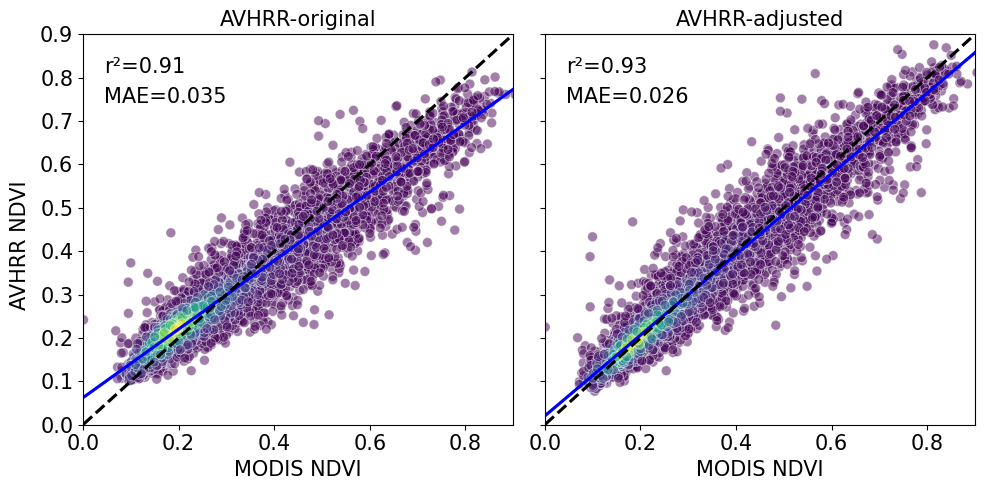

In [7]:
products=['AVHRR-original', 'AVHRR-adjusted']

fig,ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
font=15

for prod, ax in zip(products, ax.ravel()):
    obs,pred = df_sample['MODIS'].values, df_sample[prod].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_sample, x='MODIS',y=prod, c=z, s=50, lw=1, alpha=0.5, ax=ax)
    sb.regplot(data=df_sample, x='MODIS',y=prod, scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_sample, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    ax.set_title(prod, fontsize=font)
    ax.set_xlabel('MODIS NDVI', fontsize=font)
    ax.set_ylabel('')
    ax.set_ylim(0,0.9)
    ax.set_xlim(0,0.9)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR NDVI', fontsize=font)
plt.tight_layout();

## Per-pixel Correlations

In [8]:
adjusted_corr = xr.corr(merge.ndvi_mcd.sel(time=slice('2001', '2013')),
                        merge.ndvi_mcd_pred.sel(time=slice('2001', '2013')), 
                        dim='time'
                       )

orig_corr = xr.corr(merge.ndvi_mcd.sel(time=slice('2001', '2013')),
                        merge.ndvi_cdr.sel(time=slice('2001', '2013')), 
                        dim='time'
                       )

/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [9]:
corr_data = [orig_corr, adjusted_corr]

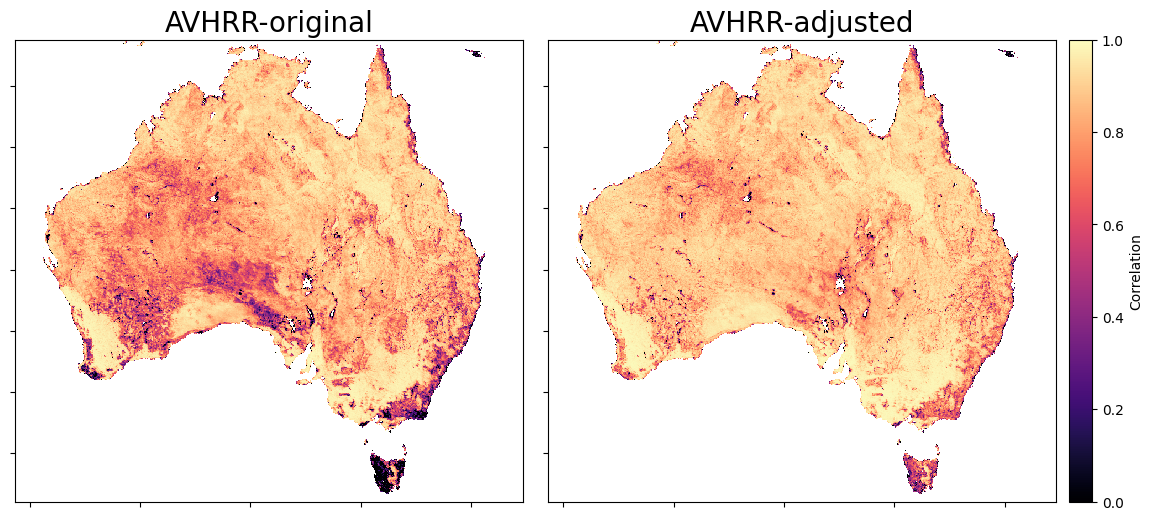

In [39]:
fig,axes = plt.subplots(1,2, figsize=(16,6), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    im = ds.plot.imshow(vmin=0, vmax=1.0, cmap='magma', ax=ax, add_colorbar=False)
    ax.set_title(n,  fontsize=20);
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

fig.subplots_adjust(wspace=0.05)
fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.01, label='Correlation');
# plt.tight_layout();